# Waveform fitting

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import pwca
from pwca import determine_data_fitting_region,pwca_catalog,metadata_dict

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"
(pwca.core)>> Metadata dictionary for Ed's catalog paper stoed to "pwca.catalog_paper_metadata"


## This notebook is for prototyping and scratch code only. Please see scripts with same issue number.

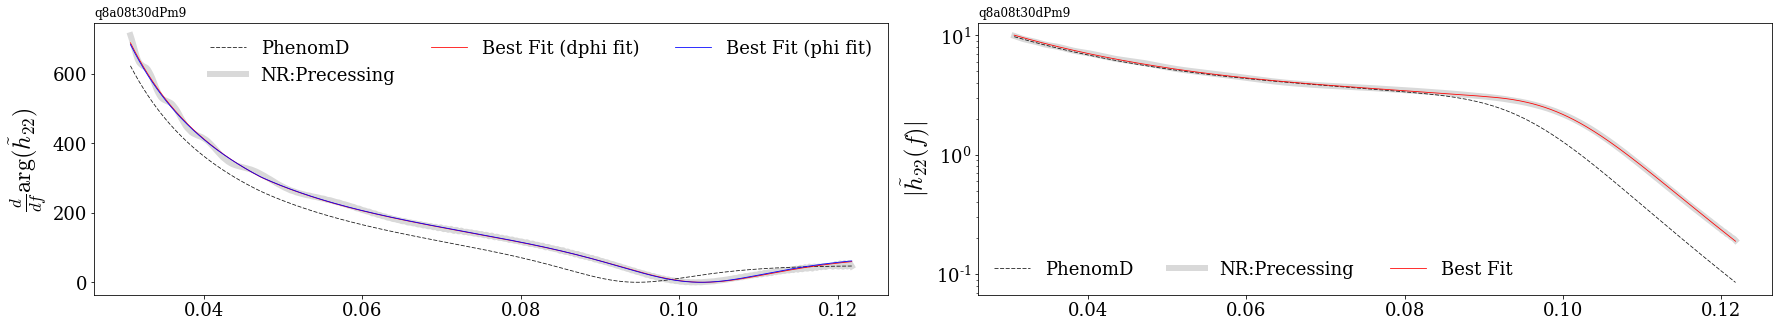

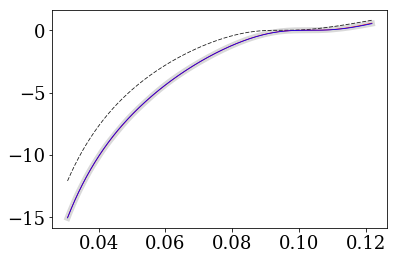

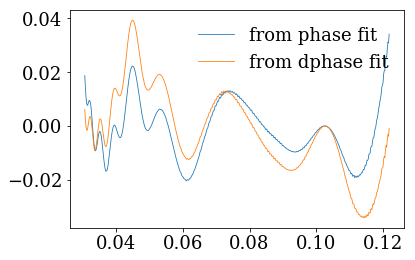

In [14]:

#
from numpy.linalg import norm
from scipy.optimize import curve_fit

#
datadir = '/Users/book/KOALA/puck/ll/data/version2/'
files = glob( datadir+'*.txt' )

#
# fig,ax = subplots( len(files), 2, figsize=3*array([ 2.5*2/(0.618), 1.5*len(files) ]) )
fig,ax = subplots( 1, 2, figsize=3*array([ 2.5*2/(0.618), 1.5*1 ]) )
ax = ax.flatten()

#
tight_layout(1,2,4)

#
foo = {}

#
p = 0
for f_ in files[::-1]:
    
    if 'q8a08t30' in f_:#'q8a08t30' in f_:

        #
        simname = f_.split('/')[-1].split('.')[0]

        # Find index location of metadata for simname 
        k = list( metadata_dict['simname'] ).index(simname)

        # Load data for this case
        raw_data = loadtxt(f_).T
        data,_,fmin,fmax,fknot = determine_data_fitting_region(raw_data)

        # Collect params for this case 
        metadata = metadata_dict['array_data'][k,:]

        #
        f,amp_td,amp_fd,dphi_td,dphi_fd,phi_td,phi_fd = data.T
        theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2 = metadata_dict['array_data'][k]

        # GENERATE TEMPLATE FUNCTIONS
        # ---
        template_amp, template_dphi, template_phi = pwca.template_amp_phase(m1, m2, chi1, chi2, chi_p)
        

        # PHASE 
        # ---

        #
        phenomd_phi = template_phi(f)
        phi_popt, phi_pcov = curve_fit(template_phi, f, phi_td,p0=[0,0,0,0])
        best_fit_phi = template_phi(f,*phi_popt)

        # PHASE DERIVATIVE
        # ---

        #
        phenomd_dphi = template_dphi(f)
        dphi_popt, dphi_pcov = curve_fit(template_dphi, f, dphi_td,p0=[0,0,0,0])
        best_fit_dphi = template_dphi(f,*dphi_popt)
        best_fit_dphi2 = template_dphi(f,*phi_popt)
        best_fit_phi_from_dphi_fit = template_phi(f,*dphi_popt)

        # AMPLITUDE
        # ---

        #
        amp_scale = f ** (7.0/6)
        inv_amp_scale = f ** (-7.0/6)

        #
        log_scaled_template_amp = lambda X,MU0,MU1,MU2,MU3,MU4: log(  template_amp(X,MU0,MU1,MU2,MU3,MU4)*amp_scale  )
        phenomd_amp = template_amp(f)

        #
        scaled_amp_fd = amp_fd * amp_scale
        log_scaled_amp_fd = log(scaled_amp_fd)
        log_scaled_amp_popt, log_amp_pcov = curve_fit(log_scaled_template_amp, f, log_scaled_amp_fd,p0=[0,0,0,0,0])
        best_fit_amp = exp(log_scaled_template_amp(f,*log_scaled_amp_popt)) * inv_amp_scale

        # PLOTTING
        # ---


        #figure( figsize=1.5*figaspect(0.5*0.618/2) )

        #subplot(1,2,1)
        sca(ax[p]); p+=1
        plot( f, phenomd_dphi, label='PhenomD', ls='--',alpha=0.9,color='k' )
        plot( f, dphi_td, label='NR:Precessing', color='k', alpha=0.15, lw=6 )
        plot( f, best_fit_dphi, label='Best Fit (dphi fit)', color='r', ls='-' )
        plot( f, best_fit_dphi2, label='Best Fit (phi fit)', color='b', ls='-' )
        title(simname,size=12,loc='left')
        legend(ncol=3,loc=1)
        ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$')
        if p==(len(files)-2):  xlabel('$fM$')
        #
        title(f_.split('/')[-1].split('.')[0],loc='left',size=12)

        #subplot(1,2,2)
        sca(ax[p]); p+=1
        plot( f, phenomd_amp, label='PhenomD', ls='--',alpha=0.9,color='k' )
        plot( f, amp_fd, label='NR:Precessing', color='k', alpha=0.15, lw=6 )
        plot( f, best_fit_amp, label='Best Fit', color='r', ls='-' )
        title(simname,size=12,loc='left')
        yscale('log')
        legend(ncol=3,loc=3)
        ylabel(r'$|\tilde{h}_{22}(f)|$')
        #
        title(f_.split('/')[-1].split('.')[0],loc='left',size=12)
        
        #
        figure()
        mask = (f>0.03) & (f<0.12)
        plot( f, phenomd_phi, label='PhenomD', ls='--',alpha=0.9,color='k' )
        plot( f, phi_td, label='NR:Precessing', color='k', alpha=0.15, lw=6 )
        plot( f, best_fit_phi, label='Best Fit', color='r', ls='-' )
        plot( f, best_fit_phi_from_dphi_fit, label='Best Fit 2', color='b', ls='-' )

        figure()
        plot( f,best_fit_phi-phi_td, label='from phase fit' )
        plot( f,best_fit_phi_from_dphi_fit-phi_td, label='from dphase fit' )
        legend()
        
        #
        break
        
    

In [15]:
dphi_popt

array([ 0.19001591,  0.0212084 ,  0.00731749, -0.54441291])

In [16]:
print around( dphi_popt, 4 )
print around( phi_popt, 4 )
print abs(phi_popt-dphi_popt)

[ 0.19    0.0212  0.0073 -0.5444]
[ 0.183   0.0205  0.0065 -0.4279]
[0.00697128 0.00066231 0.00078652 0.11649948]


In [24]:
# ?curve_fit

In [3]:
?spline_diff

Signature: spline_diff(t, y, k=3, n=1)
Docstring: Wrapper for InterpolatedUnivariateSpline derivative function
File:      ~/JOKI/Libs/KOALA/positive_dev/positive/maths.py
Type:      function


In [ ]:

figure()

for d in data:
    
    f,amp_td,amp_fd,dphi_td,dphi_fd = d.T
    
    plot( f, dphi_td-min(dphi_td) )

(-0.7266398012230191, 731.7166240000845)

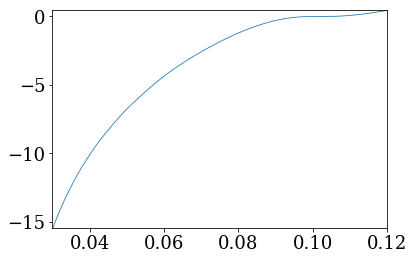

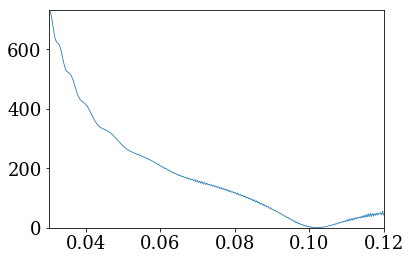

In [43]:
f,_,_,_,_,phi_td,_ = raw_data

#
fmin,fmax = 0.03,0.12

figure()
plot( f, phi_td )
xlim(fmin,fmax)
ylim( lim(phi_td[(f>fmin)&(f<fmax)]) )

#
dphi = spline_diff(f,phi_td)
# shift = 

figure()
plot( f, dphi )
xlim(0.03,0.12)
ylim( lim(dphi[(f>fmin)&(f<fmax)]) )

In [97]:
from scipy.optimize import minimize

In [99]:
# ?minimize